**Sampling the joint posterior of a hierarchical Gaussian**

In this code, we are going to show how to generate samples from the joint posterior of a hierarchical Gaussian, where we consider that the mean and precision of the Gaussian variable are also random parameters. If you have any questions, you can contact the instructor.

Suppose that we observe $x_1,..., x_N \sim \mathcal{N}(x_i|\mu, \lambda^{-1})$.

For simplicity, we assume that the mean $\mu$ and the precision $\lambda$ are independent random variables, so the joint is the product of the two marginals: $p(\mu, \lambda) = p(\mu)p(\lambda)$, where we assume the following marginals:
 * The mean $\mu$ follows a Gaussian variable with zero-mean and precision $\omega$: $\mu \sim \mathcal{N}(\mu|0, \omega^{-1})$
 * The precision $\lambda$ follows a Gamma distribution, with parameters $\alpha$ and $\beta$: $\lambda \sim \mathcal{G}(\lambda|\alpha, \beta)$

Our objective is to sample from the joint posterior $p(\mu, \lambda|x)$. As seen in class, direct application of Bayes' Theorem is complex in this case, and we can instead use the fact that we can derive the marginals $p(\mu|x, \lambda)$ and $p(\lambda|x, \mu)$, and then sample from the joint using Gibbs sampling (although we do not know the joint, we can sample from it!).

The first thing we need to do is to import the necessary libraries. We will use numpy to generate the samples and matplotlib to plot the results. We will also use the magic command `%matplotlib inline` to show the plots in the notebook.

In [6]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

First, we will generate random samples for the mean and precision, and then we will generate the data we observe. We will use the following values for the parameters (although you can change them in the code):
 * $\omega = 2$
 * $\alpha = 1$
 * $\beta = 0.2$

In [7]:
# First, sample the mean and precision from their priors
n_samples = 3000  # Number of samples obtained
omega = 2  # Precision parameter for the mean
mu_sample = np.random.randn(1) / np.sqrt(omega)
alpha = 1.0  # Gamma parameter for precision
beta = 0.2  # Gamma parameter for precision
precision_sample = np.random.gamma(shape=alpha, scale=1/beta, size=1)

# Second, sample the values we observe
x = np.random.randn(n_samples) / np.sqrt(precision_sample) + mu_sample

We are now ready to sample from the joint posterior. We will use Gibbs sampling, which is an iterative method that updates the parameters incrementally. The algorithm is as follows:
 * Initialize the parameters $\mu$ and $\lambda$ to some value (e.g., zero)
 * For each iteration:
   * Sample $\mu$ from $p(\mu|x, \lambda)=\mathcal{N}\left(\mu \Big| N \lambda +\omega, \left( \frac{\lambda}{N \lambda +\omega} \sum_i x_i \right)^{-1} \right)$
   * Sample $\lambda$ from $p(\lambda|x, \mu)=\mathcal{G}\left(\lambda \Big| \alpha + \frac{N}{2}, \beta + \frac{1}{2} \sum_i (x_i-\mu)^2\right)$
 * Repeat until convergence

This procedure is directly implemented in the following code: note that `x_gibbs` contains the sampled values of $\mu$ and $\lambda$.

In [8]:
n_iter = 1000
x_gibbs = np.zeros((n_iter, 2))  # Matrix to store the values of the joint distribution
prev_value = np.array([0.0, 0.0])  # Initial value to start sampling

for i in range(n_iter):  # Gibbs method: update incrementally

    lambda_n = n_samples * prev_value[1] + omega
    mu_n = prev_value[1] / lambda_n * np.sum(x)
    prev_value[0] = np.random.randn(1) / np.sqrt(lambda_n) + mu_n

    alpha_n = alpha + n_samples / 2
    beta_n = beta + 0.5 * np.sum(np.square(x - prev_value[0]))
    prev_value[1] = np.random.gamma(shape=alpha_n, scale=1/beta_n, size=1)

    x_gibbs[i, :] = prev_value  # Save the new sample obtained

With the samples obtained, we can now sample new data from the distribution $x\sim \mathcal{N}(x_i|\mu, \lambda^{-1})$. We need only be careful with the burn-in period: the first samples must be discarded, as they do not correspond to the real distribution. We will use a burn-in period of 100 samples. Note that the results are very close to the real values.

In [9]:
burnin = 100  # Samples to drop (burn-in period)
mu_estimated = x_gibbs[burnin:, 0]
precision_estimated = x_gibbs[burnin:, 1]
x_new = np.random.randn(mu_estimated.size) / np.sqrt(precision_estimated) + mu_estimated  # New data generated using estimated parameters

print('Original values: mu = ', mu_sample[0], '; precision = ', precision_sample[0])
print('Estimated values (average): mu = ', np.mean(mu_estimated), '; precision = ', np.mean(precision_estimated))

Original values: mu =  0.681778337918214 ; precision =  1.2938008186462429
Estimated values (average): mu =  0.7071132942130474 ; precision =  1.2597007442273949


Finally, we can plot the results. We will plot:

* The Gibbs samples obtained for $\mu$ and $\lambda$.
* The evolution of $\mu$ and $\lambda$ during the Gibbs sampling, where you can notice the burn-in period clearly, as well as how the sampled data fits the real distribution.
* The histogram of the original data and the data generated using the estimated parameters, as well as the original and estimated pdfs. You can check that both histograms are very similar, and that the estimated pdfs are very close to the original one, which indicates that the procedure follows has been successful. Note that each Gibbs sample yields a pair of $(\mu, \lambda)$, that is, a distribution for $x$. We only plot $5$ of the estimated distributions in order not to difficult the visualization: note that they are always very similar to the real ones.

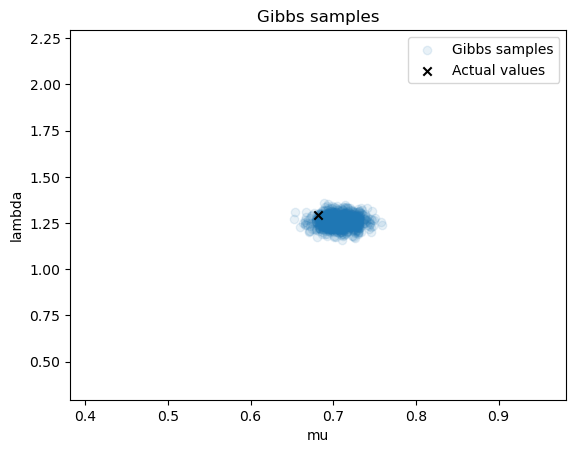

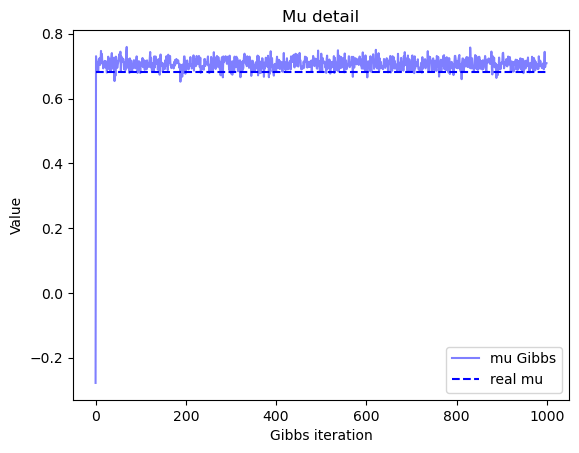

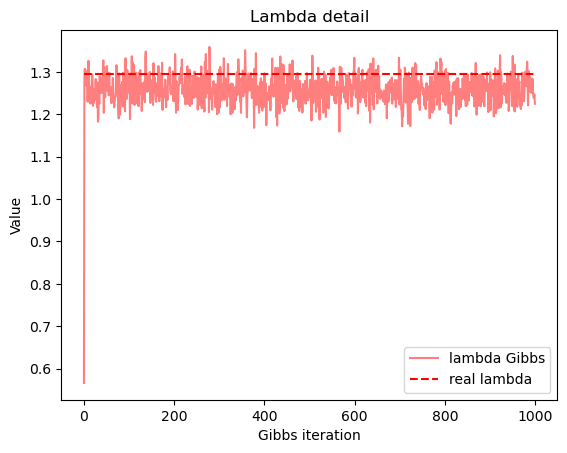

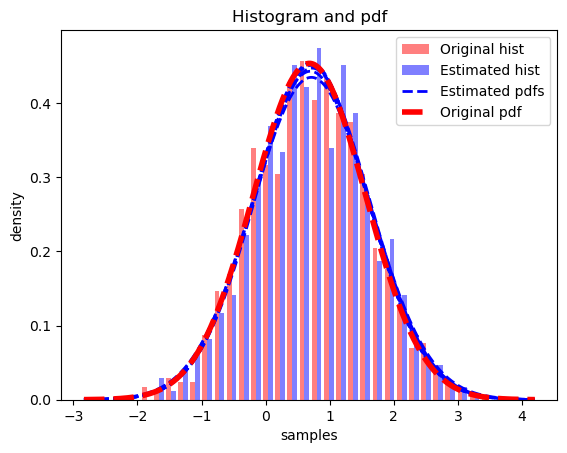

In [10]:
# Plotting
plt.scatter(x_gibbs[:, 0], x_gibbs[:, 1], marker='o', alpha=0.1, label='Gibbs samples')
plt.scatter(mu_sample, precision_sample, marker='x', color='k', label='Actual values')
plt.xlabel('mu')
plt.ylabel('lambda')
plt.legend(loc='best')
plt.axis([mu_sample - 0.3, mu_sample + 0.3, precision_sample - 1, precision_sample + 1])
plt.title('Gibbs samples')
plt.show()

plt.plot(x_gibbs[:, 0], c='b', alpha=0.5, label='mu Gibbs')
plt.plot(mu_sample * np.ones((n_iter, )), c='b', linestyle='dashed', label='real mu')
plt.xlabel('Gibbs iteration')
plt.ylabel('Value')
plt.legend(loc='best')
plt.title('Mu detail')
plt.show()

plt.plot(x_gibbs[:, 1], c='r', alpha=0.5, label='lambda Gibbs')
plt.plot(precision_sample * np.ones((n_iter, )), c='r', linestyle='dashed', label='real lambda')
plt.xlabel('Gibbs iteration')
plt.ylabel('Value')
plt.legend(loc='best')
plt.title('Lambda detail')
plt.show()

x = x[:mu_estimated.size]  # This is only to avoid warnings due to difference in the number of samples between the real and generated data

plt.hist([x, x_new], bins=30, density=True, color=['r', 'b'], label=['Original hist', 'Estimated hist'], alpha=0.5)  # Histogram: with original and estimated values
x_range = np.linspace(mu_sample - 4 / np.sqrt(precision_sample), mu_sample + 4 / np.sqrt(precision_sample), mu_estimated.size)

pdf = [1/(np.sqrt(2*np.pi / precision_sample) ) * np.exp(-np.square((x_range - mu_sample) * np.sqrt(precision_sample)) / 2 )] + [1/(np.sqrt(2*np.pi / le) ) * np.exp(-np.square((x_range - mue) * np.sqrt(le)) / 2 ) for mue, le in zip(list(mu_estimated), list(precision_estimated))]  # Original + One pdf per posterior sample

plt.plot(x_range, pdf[1], color='b', linewidth=2, linestyle='dashed', label='Estimated pdfs')
for i in range(5):  # Plot only 5 (+1) posterior pdfs
  plt.plot(x_range, pdf[2 + i], color='b', linewidth=2, linestyle='dashed')  # The reason to have one pdf out of the loop is to prevent multiple labels
plt.plot(x_range, pdf[0], color='r', linewidth=4, linestyle='dashed', label='Original pdf')

plt.xlabel('samples')
plt.ylabel('density')
plt.title('Histogram and pdf')
plt.legend(loc='best')
plt.show()